In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random

In [2]:
dataset_dir = "/kaggle/input/msrdailyactivity3d-rgb-videos-only/MSRDailyAction3D"

# list of classes
all_classes = os.listdir(dataset_dir)

# set number of classes
NO_OF_CLASSES = 10
classes=all_classes[:NO_OF_CLASSES]

max_video_per_class = 100
sequence_length = 15

image_height = 224
image_width = 224
resize_frame_height = 128
resize_frame_width = 128

print(classes)

['write on a paper', 'use laptop', 'read book', 'sit still', 'drink', 'sit down', 'use vacuum cleaner', 'eat', 'play guitar', 'lie down on sofa']


In [3]:
def create_dataset(dataset_dir=dataset_dir, classes=classes, max_video_per_class=None):
    video_paths = []
    labels = []
    
    for selected_class in classes:
        selected_class_path = os.path.join(dataset_dir, selected_class)
        video_names =  os.listdir(selected_class_path)

        if max_video_per_class is not None:
            video_names = video_names[:max_video_per_class]
        
        for video_path in video_names:
            video_path = os.path.join(dataset_dir, selected_class, video_path)
            video_paths.append(video_path)
            labels.append(selected_class)

    return video_paths, labels

In [4]:
# create dataset
video_paths, labels = create_dataset(max_video_per_class=max_video_per_class)

In [6]:
combined = zip(labels, video_paths)

for label, video_name in combined:
     print(label, ":" , video_name)

write on a paper : /kaggle/input/msrdailyactivity3d-rgb-videos-only/MSRDailyAction3D/write on a paper/a05_s05_e01_rgb.avi
write on a paper : /kaggle/input/msrdailyactivity3d-rgb-videos-only/MSRDailyAction3D/write on a paper/a05_s03_e01_rgb.avi
write on a paper : /kaggle/input/msrdailyactivity3d-rgb-videos-only/MSRDailyAction3D/write on a paper/a05_s04_e01_rgb.avi
write on a paper : /kaggle/input/msrdailyactivity3d-rgb-videos-only/MSRDailyAction3D/write on a paper/a05_s07_e01_rgb.avi
write on a paper : /kaggle/input/msrdailyactivity3d-rgb-videos-only/MSRDailyAction3D/write on a paper/a05_s03_e02_rgb.avi
write on a paper : /kaggle/input/msrdailyactivity3d-rgb-videos-only/MSRDailyAction3D/write on a paper/a05_s09_e01_rgb.avi
write on a paper : /kaggle/input/msrdailyactivity3d-rgb-videos-only/MSRDailyAction3D/write on a paper/a05_s04_e02_rgb.avi
write on a paper : /kaggle/input/msrdailyactivity3d-rgb-videos-only/MSRDailyAction3D/write on a paper/a05_s07_e02_rgb.avi
write on a paper : /kagg

In [ ]:
input("")

In [7]:
# encoding
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Assume your labels look like this:
# labels = ['write on a paper', 'run', 'jump', 'write on a paper', ...]

# Step 1: Convert string labels to integers
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)  # e.g., [2, 0, 1, 2, ...]

# Step 2: Convert to one-hot encoded format
one_hot_encoded_labels = to_categorical(integer_encoded)

print(one_hot_encoded_labels)

2025-06-29 17:32:27.934757: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751218348.400005      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751218348.523485      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


In [8]:
from tensorflow.keras.utils import Sequence

# Define your data generator
class VideoDataGenerator(Sequence):
    def __init__(self, video_paths, labels, batch_size):
        self.video_paths = video_paths  # List of sequences, where each sequence is a list of frames
        self.labels = labels
        self.batch_size = batch_size
        self.indices = np.arange(len(self.video_paths))
    
    def __len__(self):
        # Return the number of batches per epoch
        return int(np.ceil(len(self.video_paths) / self.batch_size))
    
    def __getitem__(self, idx):
        # Get batch of video sequences and corresponding labels
        batch_video_paths = self.video_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        augmented_frames = []
        expanded_labels = []

        for video_path, label in zip(batch_video_paths, batch_labels):
            sequence = self.frame_extraction(video_path)
            
            # Original
            augmented_frames.append(sequence)
            expanded_labels.append(label)

            # Augmentations
            augmented_frames.append(self.horizontal_flip(sequence))
            expanded_labels.append(label)

            augmented_frames.append(self.random_shear_frames(sequence))
            expanded_labels.append(label)

            augmented_frames.append(self.salt_and_pepper_noise_frames(sequence))
            expanded_labels.append(label)
            
            augmented_frames.append(self.apply_all_augmentation(sequence))
            expanded_labels.append(label)

        return np.array(augmented_frames, dtype=np.float32), np.array(expanded_labels)
    
    def frame_extraction(self, video_path, sequence_length=sequence_length, image_width=image_width, image_height=image_height):
             # Declare a list to store video frames
        frames_list = []
    
        # Check if video file exists
        if not os.path.exists(video_path):
            print(f"Error: Video file not found at {video_path}")
            return None
    
        # Read the video file using VideoCapture
        video_reader = cv2.VideoCapture(video_path)
    
        # Check if the video was opened successfully
        if not video_reader.isOpened():
            print(f"Error: Could not open video file {video_path}")
            video_reader.release()
            return None
    
        # Get the total number of frames in the video
        video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    
        # Ensure the video has enough frames
        if video_frames_count < sequence_length:
            print(f"Warning: Video {video_path} has only {video_frames_count} frames, less than required {sequence_length}")
            video_reader.release()
            return None
    
        # Calculate the interval after which frames will be sampled
        skip_frames_window = max(int(video_frames_count / sequence_length), 1)
    
        # Iterate to extract the specified number of frames
        for frame_counter in range(sequence_length):
            # Set the current frame position
            video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
    
            # Read the frame
            success, frame = video_reader.read()
    
            # Check if the frame was read successfully
            if not success or frame is None:
                print(f"Warning: Failed to read frame {frame_counter} from {video_path}")
                break
    
            # Resize the frame to the specified dimensions
            try:
                resized_frame = cv2.resize(frame, (image_width, image_height))
            except Exception as e:
                print(f"Error resizing frame {frame_counter} from {video_path}: {e}")
                break
            # Normalize the frame to [0, 1] for model input
            rgb_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB)
            normalized_frame = rgb_frame / 255.0
            
    
            # Append the normalized frame to the list
            frames_list.append(normalized_frame)
    
        # Release the VideoCapture object
        video_reader.release()
    
        # Ensure the correct number of frames is extracted
        if len(frames_list) != sequence_length:
            print(f"Warning: Extracted {len(frames_list)} frames instead of {sequence_length} from {video_path}")
            return None
    
        # Convert to numpy array for consistency
        frames_list = np.array(frames_list)
    
        return frames_list
    def horizontal_flip(self,frames):
        # Flip each frame in the sequence
        return [cv2.flip(frame, 1) for frame in frames]

    def random_shear_frames(self,frames):
        # Shear each frame in the sequence
        return [self.random_shear(frame) for frame in frames]

    def random_shear(self,frame):
        shear_x = random.uniform(-0.09, 0.09)
        shear_y = random.uniform(0.1, 0.3)
        height, width = frame.shape[:2]
        M = np.float32([[1, shear_x, 0], [shear_y, 1, 0]])
        return cv2.warpAffine(frame, M, (width, height))

    def salt_and_pepper_noise_frames(self,frames):
        # Add salt and pepper noise to each frame in the sequence
        return [self.salt_and_pepper_noise(frame) for frame in frames]

    def salt_and_pepper_noise(self,frame, amount=0.02):
        output = np.copy(frame)
        total_pixels = frame.size
        num_salt = int(total_pixels * amount)
        num_pepper = int(total_pixels * amount)
        
        for _ in range(num_salt):
            i = random.randint(0, frame.shape[0] - 1)
            j = random.randint(0, frame.shape[1] - 1)
            output[i, j] = 255  # Salt (white pixel)
        
        for _ in range(num_pepper):
            i = random.randint(0, frame.shape[0] - 1)
            j = random.randint(0, frame.shape[1] - 1)
            output[i, j] = 0  # Pepper (black pixel)
        return output
        
    def apply_all_augmentation(self, frames):
        frames = self.horizontal_flip(frames)
        frames = self.random_shear_frames(frames)
        frames = self.salt_and_pepper_noise_frames(frames)
        return frames
        
    def on_epoch_end(self):
        self.indices = np.arange(len(self.video_paths))
        pass


In [9]:
generator = VideoDataGenerator(video_paths=video_paths, labels=one_hot_encoded_labels, batch_size=4)

In [10]:
gen_videos, gen_labels = generator[0]

In [11]:
len(gen_videos)

20

In [12]:
import matplotlib.pyplot as plt
import numpy as np
def show_video_frames(video_frames, num_to_show=5):
    plt.figure(figsize=(15, 5))
    
    for i in range(min(num_to_show, len(video_frames))):
        plt.subplot(1, num_to_show, i + 1)
        plt.imshow(video_frames[i])
        plt.title(f"Frame {i}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [13]:
# Assuming generator is already created
gen_videos, gen_labels = generator[0]  # gen_videos shape: (batch_size,), dtype=object

# Debug: Check shape and dtype
print(gen_videos.shape, gen_videos.dtype)  # Should be (batch_size,), object
print(gen_videos[0].shape, gen_videos[0].dtype)  # Should be (sequence_length, image_height, image_width, 3), float64



(20, 15, 224, 224, 3) float32
(15, 224, 224, 3) float32


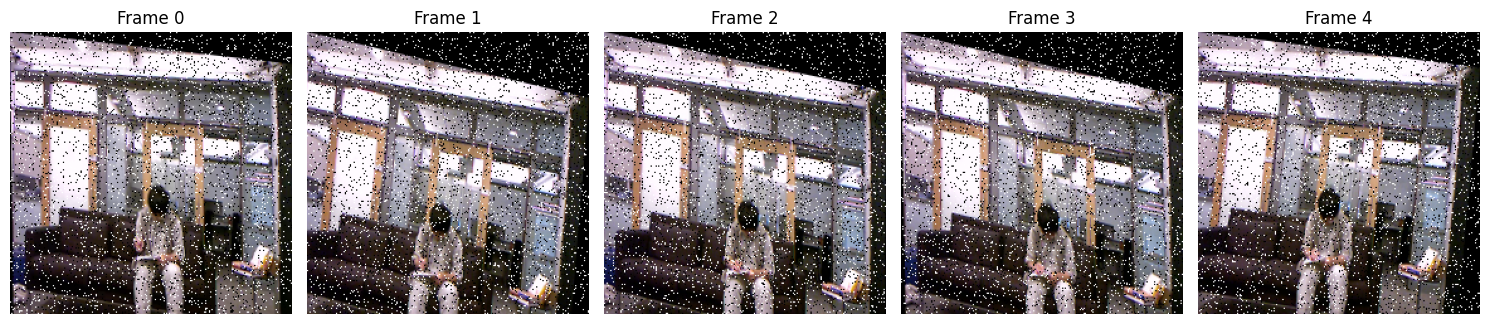

In [14]:
# Visualize the first sequence
show_video_frames(gen_videos[4])